CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed, MLP, preprocess_dataset, split_dataset, DataLoader, CustomDataset

# setting seed
set_seed()

Define the model class.

In [2]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [3]:
# Load dataset
df = pd.read_csv('audio_gtzan.csv')

df['label'] = df['filename'].str.split('.').str[0]
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df['label'].value_counts()

# Split dataset
random_states = 42
X_train, y_train, X_test, y_test = split_dataset(df, ['filename', 'label'], 0.3, random_states)

# Scale input features
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

# Define PyTorch Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:

no_features = X_train_scaled.shape[1]  # Number of input features
no_labels = 2   
no_hidden = 128
df


,filename,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,0
1,blues.00000.1.wav,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,0
2,blues.00000.2.wav,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,0
3,blues.00000.3.wav,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,0
4,blues.00000.4.wav,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,metal.00099.5.wav,0.569740,0.062489,0.183593,0.002789,2535.203233,270668.548858,2291.959926,58613.589717,5130.285645,...,21.712755,-4.158046,29.863869,9.435037,26.915369,0.012259,23.633455,3.567852,28.382370,1
1996,metal.00099.6.wav,0.515344,0.070363,0.163011,0.002171,2343.927920,196117.813927,2247.395310,52294.899740,4876.525128,...,22.578876,-5.004858,20.476982,7.884581,23.147270,0.954583,40.513123,3.694663,13.842016,1
1997,metal.00099.7.wav,0.516211,0.076836,0.192291,0.002663,2391.415667,210603.079200,2310.871644,30626.337841,5062.041955,...,31.324835,-4.537669,27.974548,8.396358,20.044083,0.623945,28.704712,2.352662,17.750040,1
1998,metal.00099.8.wav,0.535496,0.069590,0.164871,0.002717,2250.460272,164674.801773,2198.307164,33464.557313,4684.962440,...,18.584599,-5.836212,9.423578,7.213720,16.957996,0.295297,23.082623,2.749243,16.626318,1


> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [5]:
class CustomDataset(Dataset):
    # create CustomDataset class
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.long)

        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # create CustomDataset objects for train and test data
    train_data = CustomDataset(X_train_scaled, y_train)
    test_data = CustomDataset(X_test_scaled, y_test)
    # create DataLoader objects for train and test data
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

In [6]:
# print(np.bincount(y_train))
# print(np.bincount(y_test))
# class_counts = np.bincount(y_train)
# class_weights = 1. / class_counts
# sample_weights = [class_weights[y] for y in y_train]
# loss_fn = nn.BCELoss(weight=torch.tensor(sample_weights))


In [7]:
print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape, y_test.shape)

(1400, 57) (1400,)
(600, 57) (600,)


In [8]:
print("Unique labels in train:", np.unique(y_train))
print("Unique labels in test:", np.unique(y_test))


Unique labels in train: [0 1]
Unique labels in test: [0 1]


2. Next, define the model, optimizer and loss function.

In [9]:

model = MLP(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [10]:
# train and test functions
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
        train_correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
        
    train_loss /= size
    train_correct /= size
    
    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(dim=1)==y).type(torch.float).sum().item()

    test_loss /= size
    test_correct /= size

    return test_loss, test_correct

In [11]:
# Training setup
from common_utils import EarlyStopper
early_stopper = EarlyStopper(patience=3, min_delta=0)
no_epochs = 100


train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []

for epoch in range(no_epochs):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
    
    train_loss_.append(train_loss), train_acc_.append(train_acc)
    test_loss_.append(test_loss), test_acc_.append(test_acc)

    print(f"Epoch {epoch+1}: Train_accuracy: {(100*train_acc):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_acc):>0.2f}%, Test_loss: {test_loss:>8f}")

    if early_stopper.early_stop(test_loss):
        print("Done!")
        break

/home/priya/.local/lib/python3.10/site-packages/torch/autograd/graph.py:769: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train_accuracy: 71.07%, Train_loss: 0.005379, Test_accuracy: 82.33%, Test_loss: 0.005578
Epoch 2: Train_accuracy: 84.86%, Train_loss: 0.005077, Test_accuracy: 83.83%, Test_loss: 0.005104
Epoch 3: Train_accuracy: 85.57%, Train_loss: 0.004477, Test_accuracy: 84.67%, Test_loss: 0.004409
Epoch 4: Train_accuracy: 86.07%, Train_loss: 0.003870, Test_accuracy: 86.33%, Test_loss: 0.003923
Epoch 5: Train_accuracy: 87.93%, Train_loss: 0.003488, Test_accuracy: 89.50%, Test_loss: 0.003585
Epoch 6: Train_accuracy: 90.21%, Train_loss: 0.003276, Test_accuracy: 90.00%, Test_loss: 0.003461
Epoch 7: Train_accuracy: 91.86%, Train_loss: 0.003132, Test_accuracy: 91.83%, Test_loss: 0.003363
Epoch 8: Train_accuracy: 93.14%, Train_loss: 0.003038, Test_accuracy: 91.33%, Test_loss: 0.003354
Epoch 9: Train_accuracy: 93.86%, Train_loss: 0.002959, Test_accuracy: 91.67%, Test_loss: 0.003286
Epoch 10: Train_accuracy: 94.50%, Train_loss: 0.002904, Test_accuracy: 92.50%, Test_loss: 0.003270
Epoch 11: Train_acc

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

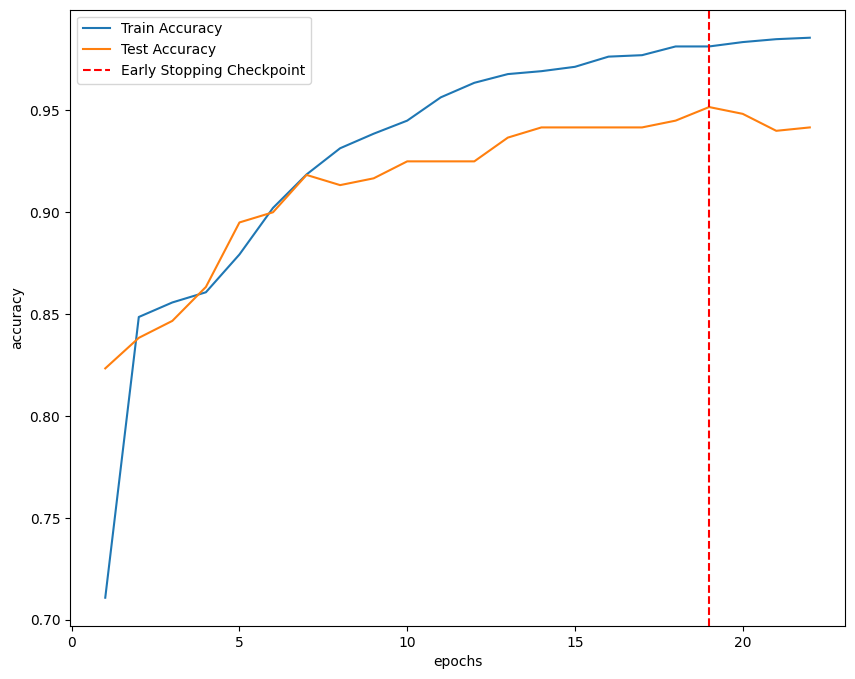

In [12]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc_)+1),train_acc_, label='Train Accuracy')
plt.plot(range(1,len(test_acc_)+1),test_acc_,label='Test Accuracy')

# find position of lowest test loss
minposs = test_loss_.index(min(test_loss_))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

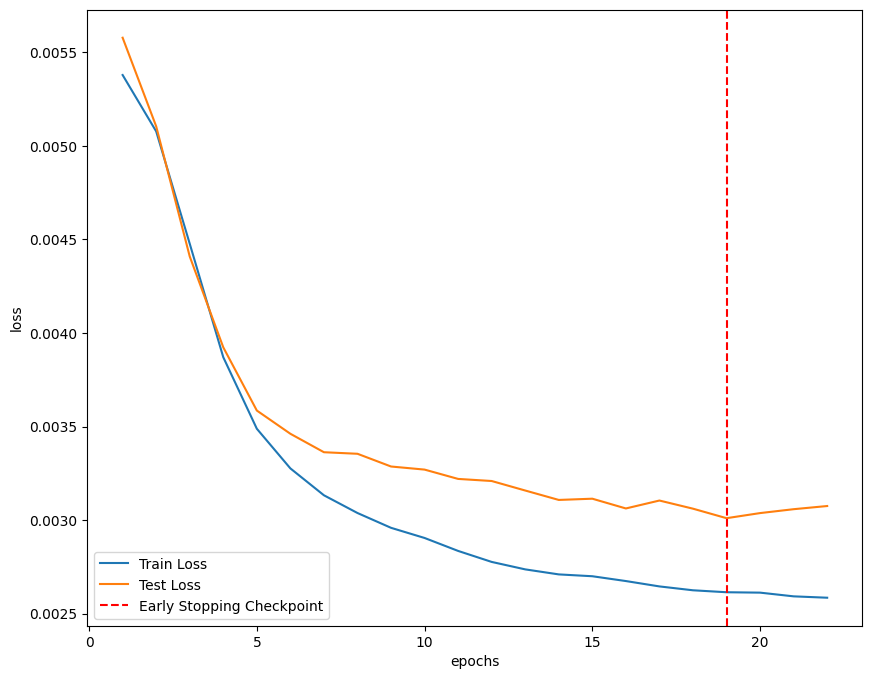

In [13]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss_)+1),train_loss_, label='Train Loss')
plt.plot(range(1,len(test_loss_)+1),test_loss_,label='Test Loss')

# find position of lowest test loss
minposs = test_loss_.index(min(test_loss_))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Comment
##Train and Validation Loss
The training loss is consistently decreasing over the epochs, indicating that the model is learning effectively from the training data and minimizing the loss function. This downward trend also suggests that the optimizer is effectively updating the weights to reduce the error on the training set.

The validation loss is also decreasing, though at a slower rate. This indicates that the model is generalizing well and is not overfitting, given that the gap between the training and validation losses remains relatively small.

Towards the end of the training, around the 18th epoch, the validation loss begins to flatten while the training loss continues to decrease. This could be an early sign that the model might start to overfit if training continues, as it improves on the training data without similar improvement on the validation data.

## Train and Validation Accuracy
The training accuracy is consistently improving over each epoch, suggesting that the model is effectively learning the patterns in the training data. The smooth upward trend reflects that the optimizer is working well to minimize the error and increase accuracy on the training set.

The validation accuracy follows a similar trend, steadily increasing, though at a slower pace. This is consistent with the behavior of the validation loss, where improvements gradually slow down as training progresses.

The gap between the training and validation accuracy remains relatively small, which is a positive sign, as it indicates that the model is not overfitting by too much and is likely to generalize well to unseen data.

## Conclusion
Overall, the model appears to be well-trained and capable of generalizing the task, as demonstrated by the relatively similar performance between the validation set and the training set. The implementation of early stopping is critical here, as it helps prevent overfitting by halting training when the validation loss plateaus. This mechanism effectively ensures that the model retains its ability to perform well on unseen data without becoming overly specialized to the training set.

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [14]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed, MLP, CustomDataset, EarlyStopper, preprocess_dataset, split_dataset

# setting seed
set_seed()


> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {32, 64, 128, 256}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [15]:
no_features = 57
no_hidden = 128
no_labels = 1

no_folds = 5

In [16]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # create KFold object
    kf = KFold(n_splits=no_folds, shuffle=True, random_state=42)

    # create dicts
    X_train_scaled_dict = {batch_size: [] for batch_size in batch_sizes}
    X_val_scaled_dict = {batch_size: [] for batch_size in batch_sizes}
    y_train_dict = {batch_size: [] for batch_size in batch_sizes}
    y_val_dict = {batch_size: [] for batch_size in batch_sizes}
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Scaling
        X_train_scaled, X_val_scaled = preprocess_dataset(X_train_fold, X_val_fold)
        
        for batch_size in batch_sizes:
            X_train_scaled_dict[batch_size].append(X_train_scaled)
            X_val_scaled_dict[batch_size].append(X_val_scaled)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)
    
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

df = pd.read_csv('audio_gtzan.csv')
df['label'] = df['filename'].str.split('.').str[0]

df['label'].value_counts()


# Remove 'filename' and 'label' columns from features
X_train = df.drop(['filename', 'label'], axis=1)
y_train = preprocessing.LabelEncoder().fit_transform(df['label'])

batch_sizes = [64, 128, 256, 512]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)

2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [17]:
from statistics import mean

In [18]:
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, parameters):
    cross_validation_accuracies = {}
    cross_validation_times = {}
    last_epoch_times = {}

    for batch_size in batch_sizes:
        fold_accuracies = []
        fold_times = []
        fold_last_epoch_times = []

        for fold in range(len(X_train_scaled_dict[batch_size])):
            start_time = time.time()

            # Dataset & Dataloader objects
            train_dataset = CustomDataset(X_train_scaled_dict[batch_size][fold], y_train_dict[batch_size][fold])
            test_dataset = CustomDataset(X_val_scaled_dict[batch_size][fold], y_val_dict[batch_size][fold])
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

            # Initialize model, loss function, and optimizer
            model = MLP(X_train.shape[1], 128, 1)
            loss_fn = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            # Training loop
            n_epochs = 15
            for epoch in range(n_epochs):
                model.train()
                if epoch == n_epochs - 1:  # If it's the last epoch
                    last_epoch_start_time = time.time()  # Start timing the last epoch
                    
                for X_batch, y_batch in train_loader:
                    y_batch = y_batch.float().unsqueeze(1)
                    y_pred = model(X_batch)
                    loss = loss_fn(y_pred, y_batch)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                if epoch == n_epochs - 1:  # If it's the last epoch
                    last_epoch_time = time.time() - last_epoch_start_time  # Calculate time for the last epoch
                    fold_last_epoch_times.append(last_epoch_time)  # Add to the list

            # Evaluation
            model.eval()
            with torch.no_grad():
                y_pred = model(test_dataset.X)
                accuracy = ((y_pred > 0.5).float() == test_dataset.y.unsqueeze(1).float()).float().mean().item()

            fold_accuracies.append(accuracy)
            fold_times.append(time.time() - start_time)

        print(fold_accuracies)
        print(fold_times)
        
        cross_validation_accuracies[batch_size] = mean(fold_accuracies)
        cross_validation_times[batch_size] = mean(fold_times)
        last_epoch_times[batch_size] = fold_last_epoch_times

    return cross_validation_accuracies, cross_validation_times, last_epoch_times

In [19]:
batch_sizes = [64, 128, 256, 512]
cross_validation_accuracies, cross_validation_times, last_epoch_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


[0.9825000166893005, 0.9800000190734863, 0.9950000047683716, 0.9850000143051147, 0.987500011920929]
[7.097527503967285, 6.953228712081909, 6.945563077926636, 6.921904802322388, 6.943202257156372]
[0.9850000143051147, 0.9800000190734863, 0.9725000262260437, 0.987500011920929, 0.9825000166893005]
[4.523836851119995, 4.342867136001587, 4.259514570236206, 4.298420667648315, 4.855547904968262]
[0.9800000190734863, 0.9750000238418579, 0.9750000238418579, 0.9850000143051147, 0.9775000214576721]
[2.6785576343536377, 3.265329360961914, 2.7687089443206787, 3.0264029502868652, 3.154109477996826]
[0.9549999833106995, 0.9599999785423279, 0.9624999761581421, 0.9725000262260437, 0.9599999785423279]
[1.6020400524139404, 1.6078944206237793, 1.6838815212249756, 1.6038100719451904, 1.9897449016571045]


In [20]:
# Print results
mean_accuracies = []

for batch_size in batch_sizes:
    print(f"Batch size: {batch_size}")
    print(f"  Average accuracy: {cross_validation_accuracies[batch_size]:.4f}")
    mean_accuracies.append(cross_validation_accuracies[batch_size])
    print(f"  Average time: {cross_validation_times[batch_size]:.2f} seconds")

# Find best batch size
best_batch_size = max(cross_validation_accuracies, key=cross_validation_accuracies.get)
print(f"\nBest batch size: {best_batch_size}")
print(f"Best average accuracy: {cross_validation_accuracies[best_batch_size]:.4f}")

Batch size: 64
  Average accuracy: 0.9860
  Average time: 6.97 seconds
Batch size: 128
  Average accuracy: 0.9815
  Average time: 4.46 seconds
Batch size: 256
  Average accuracy: 0.9785
  Average time: 2.98 seconds
Batch size: 512
  Average accuracy: 0.9620
  Average time: 1.70 seconds

Best batch size: 64
Best average accuracy: 0.9860


3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {32, 64, 128, 256}.

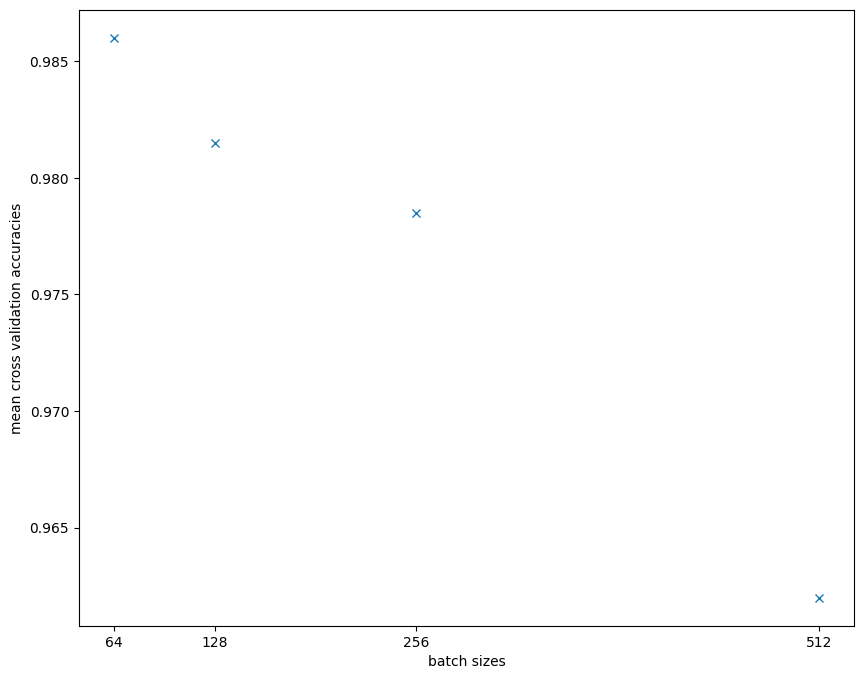

In [21]:
fig = plt.figure(figsize=(10,8))
plt.plot(batch_sizes, mean_accuracies, marker = 'x', linestyle = 'None')
plt.xticks(batch_sizes)
plt.xlabel('batch sizes')
plt.ylabel('mean cross validation accuracies')
plt.show()

4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

In [22]:
# Create lists to hold the data for the DataFrame
batch_size_list = []
last_epoch_time_list = []
fold_list = [1,2,3,4,5,1,2,3,4,5,1,2,3,4,5,1,2,3,4,5]

# Populate the lists
for batch_size in batch_sizes:
    for time in last_epoch_times[batch_size]:
        batch_size_list.append(batch_size)
        last_epoch_time_list.append(time)

# Create the DataFrame
df = pd.DataFrame({
    'Batch Size': batch_size_list,
    'Fold number': fold_list,
    'Last Epoch Time': last_epoch_time_list
})

# Print DataFrame
df

,Batch Size,Fold number,Last Epoch Time
0,64,1,0.444820
1,64,2,0.465961
2,64,3,0.464127
3,64,4,0.452581
4,64,5,0.466829
5,128,1,0.285540
6,128,2,0.200376
7,128,3,0.210479
8,128,4,0.268664
9,128,5,0.328468


In [23]:
# Checking mean last epoch time against batch sizes
print(df.groupby('Batch Size')['Last Epoch Time'].describe())

            count      mean       std       min       25%       50%       75%  \
Batch Size                                                                      
64            5.0  0.458864  0.009724  0.444820  0.452581  0.464127  0.465961   
128           5.0  0.258706  0.053419  0.200376  0.210479  0.268664  0.285540   
256           5.0  0.231181  0.088027  0.148315  0.182857  0.221530  0.224851   
512           5.0  0.105777  0.005101  0.100521  0.101860  0.104366  0.109827   

                 max  
Batch Size            
64          0.466829  
128         0.328468  
256         0.378353  
512         0.112312  


5. Select the optimal batch size and state a reason for your selection.

### optimal_batch_size = 64
### Reason 
"Batch size of 64 has the highest cross-validation accuracy, even though it has the longest average last epoch training time."

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [25]:
from common_utils import MLP, CustomDataset, EarlyStopper, preprocess_dataset
import time 

In [26]:
# Modified MLP class to vary depth of network
class FlexibleMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=0.2))
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=0.2))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [27]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    
    # Convert labels to float and reshape
    y_train2 = y_train2.float().unsqueeze(1)  # Shape: [N, 1]
    y_val2 = y_val2.float().unsqueeze(1)      # Shape: [N, 1]
    
    # Initialize datasets and dataloaders
    train_dataset = CustomDataset(X_train_scaled, y_train2)
    val_dataset = CustomDataset(X_val_scaled, y_val2)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    
    # Initialize lists to store metrics
    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []
    times = []
    
    num_epochs = 15  
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

     # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_scaled)
            val_loss = criterion(val_outputs, y_val2)
            val_predicted = (val_outputs >= 0.5).float()
            val_accuracy = (val_predicted == y_val2).sum().item() / len(y_val2)
        
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        train_losses.append(total_loss / len(train_loader))
        test_accuracies.append(val_accuracy)
        test_losses.append(val_loss.item())
        times.append(time.time() - start_time)

    
    return train_accuracies, train_losses, test_accuracies, test_losses, times


In [28]:
def generate_cv_folds(parameters, X_train, y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        # Scale the features
        X_train_scaled, X_val_scaled = preprocess_dataset(X_train_fold, X_val_fold)
        
        # Convert to PyTorch tensors
        # X_train_scaled_dict[fold].append(X_train_scaled)
        # X_val_scaled_dict[fold].append(X_val_scaled)
        # y_train_dict[fold].append(y_train_fold)
        # y_val_dict[fold].append(y_val_fold)
        X_train_scaled_dict[fold] = torch.FloatTensor(X_train_scaled)
        X_val_scaled_dict[fold] = torch.FloatTensor(X_val_scaled)
        y_train_dict[fold] = torch.FloatTensor(y_train_fold)
        y_val_dict[fold] = torch.FloatTensor(y_val_fold)
    
    return X_train_scaled_dict, y_train_dict, X_val_scaled_dict, y_val_dict

In [29]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
    
    cross_validation_accuracies = []
    cross_validation_times = []
    
    X_train_scaled_dict, y_train_dict, X_val_scaled_dict, y_val_dict = generate_cv_folds(parameters, X_train, y_train)
    
    for architecture in tqdm.tqdm(architectures):
        fold_accuracies = []
        fold_times = []
        
        for fold in range(5):

            model = FlexibleMLP(input_size=X_train.shape[1], 
                               hidden_sizes=architecture, 
                               output_size=1)  # Binary classification, so output_size=1
    
            train_accuracies, _, test_accuracies, _, times = train(
                model,
                X_train_scaled_dict[fold],
                y_train_dict[fold],
                X_val_scaled_dict[fold],
                y_val_dict[fold],
                batch_size
            )
            
            fold_accuracies.append(test_accuracies[-1]) # appending last epoch accuracy for every fold
            fold_times.append(times[-1]) # appending last epoch time for every fold
        
        cross_validation_accuracies.append(np.mean(fold_accuracies))
        cross_validation_times.append(np.mean(fold_times))
    
    return cross_validation_accuracies, cross_validation_times

In [30]:
df = pd.read_csv('audio_gtzan.csv')
df['label'] = df['filename'].str.split('.').str[0]

df['label'].value_counts()


# Remove 'filename' and 'label' columns from features
X_train = df.drop(['filename', 'label'], axis=1)
y_train = preprocessing.LabelEncoder().fit_transform(df['label'])

In [31]:
'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
optimal_bs = 64

architectures = [
    [64], [128], [256],           # 1 layer
    [64, 64], [128, 128], [256, 256],     # 2 layers
    [64, 64, 64], [128, 128, 128], [256, 256, 256]  # 3 layers
]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(), y_train, architectures, 'num_neurons', optimal_bs)

  0%|          | 0/9 [00:00<?, ?it/s]/home/priya/4001 Assignment/common_utils.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float)
/home/priya/4001 Assignment/common_utils.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)
100%|██████████| 9/9 [03:08<00:00, 20.96s/it]


2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

In [32]:
print(cross_validation_accuracies)

[0.9685, 0.9764999999999999, 0.9804999999999999, 0.9785, 0.9824999999999999, 0.9869999999999999, 0.9805000000000001, 0.9890000000000001, 0.984]


In [33]:
depth = []
width = []
for x in range(len(architectures)):
    depth.append(len(architectures[x]))
    width.append(architectures[x][0])
print(depth)
print(width)

[1, 1, 1, 2, 2, 2, 3, 3, 3]
[64, 128, 256, 64, 128, 256, 64, 128, 256]


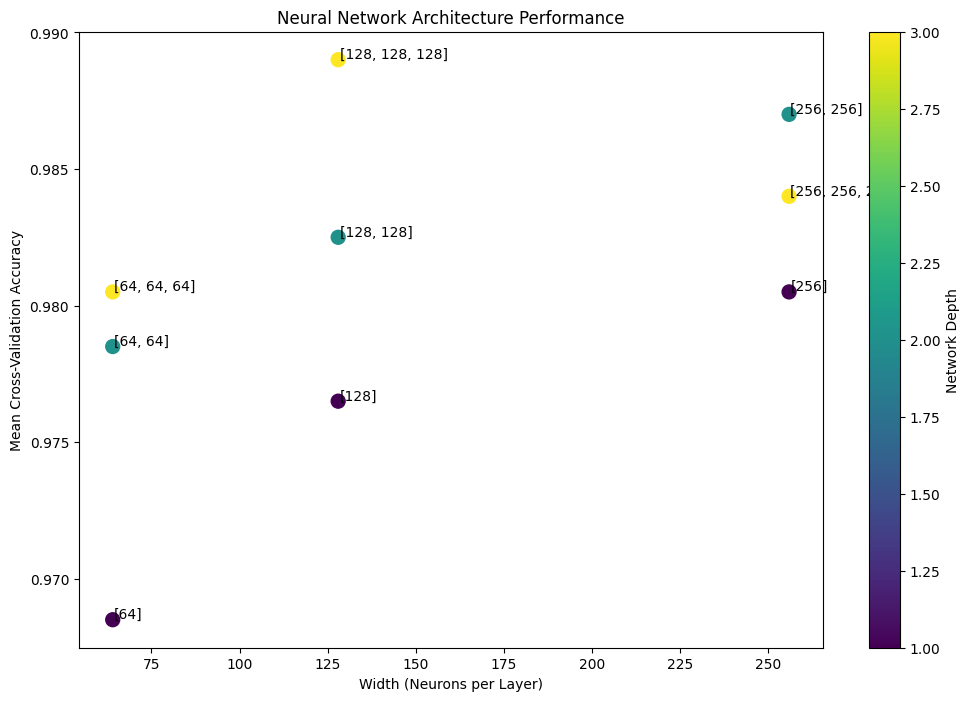

In [34]:
# Plotting
plt.figure(figsize=(12, 8))

plt.scatter(width, cross_validation_accuracies, c=depth, cmap='viridis', s=100)

# Add labels and colorbar
plt.colorbar(label='Network Depth')
plt.xlabel('Width (Neurons per Layer)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Neural Network Architecture Performance')

# Add annotations
for i in range(9):
    plt.annotate(architectures[i], 
                 (width[i], cross_validation_accuracies[i]),
                 xytext=(1, 1), textcoords='offset points')

plt.show()

> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

### Optimal_combination = "[depth=3, width=256]"

### Reason 
"This combination has the highest mean cross-validation accuracy on the validation set. Width=256 allows the network to learn more features of the dataset and therefore performs better. Depth=3 allows the network to learn more abstract representation as there are more layers to build upon features learnt from previous layers."


> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

/home/priya/4001 Assignment/common_utils.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float)
/home/priya/4001 Assignment/common_utils.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)


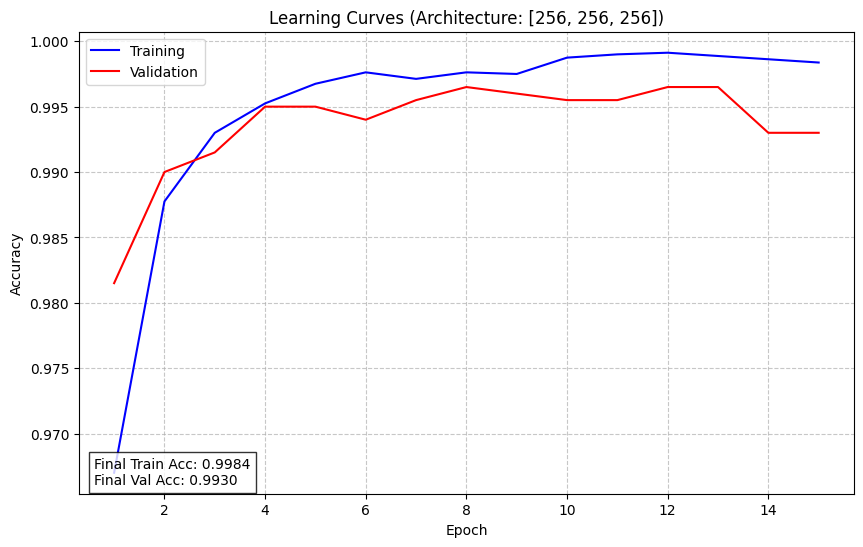

In [36]:
def plot_learning_curves(X_train, y_train, batch_size, best_architecture):

    
    # Train model with optimal architecture
    model = FlexibleMLP(input_size=X_train.shape[1], 
                        hidden_sizes=best_architecture, 
                        output_size=1)
    
    # Get cross-validation folds
    X_train_scaled_dict, y_train_dict, X_val_scaled_dict, y_val_dict = generate_cv_folds({}, X_train, y_train)
    
    # Train and collect metrics for each fold
    all_train_accuracies = []
    all_test_accuracies = []
    
    for fold in range(5):
        train_accuracies, _, test_accuracies, _, _ = train(
            model,
            X_train_scaled_dict[fold],
            y_train_dict[fold],
            X_val_scaled_dict[fold],
            y_val_dict[fold],
            batch_size
        )
        all_train_accuracies.append(train_accuracies)
        all_test_accuracies.append(test_accuracies)
    
    # Convert to numpy arrays for easier manipulation
    all_train_accuracies = np.array(all_train_accuracies)
    all_test_accuracies = np.array(all_test_accuracies)
    
    # Calculate mean accuracy across folds for every epoch
    mean_train_acc = np.mean(all_train_accuracies, axis=0)
    mean_test_acc = np.mean(all_test_accuracies, axis=0)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(mean_train_acc) + 1)
    
    # Plot mean accuracies
    plt.plot(epochs, mean_train_acc, label='Training', color='blue')
    plt.plot(epochs, mean_test_acc, label='Validation', color='red')
    
    
    plt.title(f'Learning Curves (Architecture: {best_architecture})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show final accuracies
    final_train_acc = mean_train_acc[-1]
    final_test_acc = mean_test_acc[-1]
    plt.text(0.02, 0.02, f'Final Train Acc: {final_train_acc:.4f}\nFinal Val Acc: {final_test_acc:.4f}', 
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.show()
    
    return model


best_architecture = [256, 256, 256]
best_model = plot_learning_curves(X_train.to_numpy(), y_train, batch_size=64, best_architecture=best_architecture)
# Saving Optimal Model State for A4
torch.save(best_model.state_dict(), 'pretrained_MLP.pth')

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [37]:
# YOUR CODE HERE
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()


In [38]:
from common_utils import MLP, CustomDataset, split_dataset, preprocess_dataset, FlexibleMLP

test_size =0.3
random_state = 42

df_2 = pd.read_csv('audio_gtzan.csv')
df_2['label'] = df_2['filename'].str.split('.').str[0]

df_2['label'].value_counts()
columns_to_drop = ['filename', 'label']

def preprocess(df):
    # YOUR CODE HERE
    
    # Split the dataset into training (70%) and testing (30%) sets
    # Accompanied with encoding the labels from 0 to n_classes-1 
    X_train, y_train, X_test, y_test = split_dataset(df_2, columns_to_drop, test_size, random_state)
    
    # Scale and prepare testing data
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test



X_train, y_train, X_test, y_test = preprocess(df_2)

print (df.columns)

Index(['filename', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
       'labe

> Install and import shap

In [51]:
import shap
print(shap.__version__)

0.46.0


In [52]:
import librosa
import soundfile as sf

import numpy as np
import pandas as pd

import os
from os import listdir
from os.path import isfile, join

from collections import OrderedDict

import json

In [53]:
def extract_features(filepath):
    feature_set = {}  

    try:
        y, sr = librosa.load(filepath)
        if len(y) == 0:
            print(f"Warning: {filepath} is empty or too short!")
            return None

        S = np.abs(librosa.stft(y, n_fft=512))

        # Extract features
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=512)
        chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
        chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
        melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512)
        rmse = librosa.feature.rms(y=y)[0]
        cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=512)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=512)
        contrast = librosa.feature.spectral_contrast(S=S, sr=sr, n_fft=512)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=512)
        poly_features = librosa.feature.poly_features(S=S, sr=sr, n_fft=512)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        harmonic = librosa.effects.harmonic(y)
        percussive = librosa.effects.percussive(y)

        num_mfcc = 13  # Ensure consistent MFCC dimensions
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc, n_fft=512)
        mfcc_delta = librosa.feature.delta(mfcc)

        onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
        frames_to_time = librosa.frames_to_time(onset_frames[:20], sr=sr)

        # Save extracted features
        feature_set['filename'] = filepath  
        feature_set['tempo'] = tempo  
        feature_set['total_beats'] = sum(beats) if len(beats) > 0 else 0
        feature_set['average_beats'] = np.mean(beats) if len(beats) > 0 else 0
        feature_set['chroma_stft_mean'] = np.mean(chroma_stft)  
        feature_set['chroma_stft_var'] = np.var(chroma_stft)
        feature_set['chroma_cq_mean'] = np.mean(chroma_cq)  
        feature_set['chroma_cq_var'] = np.var(chroma_cq)
        feature_set['chroma_cens_mean'] = np.mean(chroma_cens)  
        feature_set['chroma_cens_var'] = np.var(chroma_cens)
        feature_set['melspectrogram_mean'] = np.mean(melspectrogram)  
        feature_set['melspectrogram_var'] = np.var(melspectrogram)
        feature_set['mfcc_mean'] = np.mean(mfcc)  
        feature_set['mfcc_var'] = np.var(mfcc)
        feature_set['mfcc_delta_mean'] = np.mean(mfcc_delta)  
        feature_set['mfcc_delta_var'] = np.var(mfcc_delta)
        feature_set['rmse_mean'] = np.mean(rmse)  
        feature_set['rmse_var'] = np.var(rmse)
        feature_set['cent_mean'] = np.mean(cent)  
        feature_set['cent_var'] = np.var(cent)
        feature_set['spec_bw_mean'] = np.mean(spec_bw)  
        feature_set['spec_bw_var'] = np.var(spec_bw)
        feature_set['contrast_mean'] = np.mean(contrast)  
        feature_set['contrast_var'] = np.var(contrast)
        feature_set['rolloff_mean'] = np.mean(rolloff)  
        feature_set['rolloff_var'] = np.var(rolloff)
        feature_set['poly_mean'] = np.mean(poly_features)  
        feature_set['poly_var'] = np.mean(poly_features)
        feature_set['tonnetz_mean'] = np.mean(tonnetz)  
        feature_set['tonnetz_var'] = np.var(tonnetz)
        feature_set['zcr_mean'] = np.mean(zcr)  
        feature_set['zcr_var'] = np.var(zcr)
        feature_set['harm_mean'] = np.mean(harmonic)  
        feature_set['harm_var'] = np.var(harmonic)
        feature_set['perc_mean'] = np.mean(percussive)  
        feature_set['perc_var'] = np.var(percussive)
        feature_set['frame_mean'] = np.mean(frames_to_time)  
        feature_set['frame_var'] = np.var(frames_to_time)

        # Ensure consistent MFCC output
        for ix in range(num_mfcc):
            feature_set[f'mfcc{ix}_mean'] = np.mean(mfcc[ix])
            feature_set[f'mfcc{ix}_var'] = np.var(mfcc[ix])

        # Handle NaNs by checking for numeric types
        for key in feature_set:
            value = feature_set[key]
            if isinstance(value, (int, float)):  # Only check for NaNs on numeric values
                if np.isnan(value):
                    feature_set[key] = 0  

    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

    return feature_set


> Preprocess 'audio_test.wav' using the function 'extract_features' in common_utils.py. Please make sure the features are stored in a pandas dataframe, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [54]:
import IPython
IPython.display.Audio("./audio_test.wav")

In [55]:
new_features_dict = extract_features('audio_test.wav')
df = pd.DataFrame([new_features_dict])
df.to_csv('./new_record.csv', index=False)

In [56]:
# TODO: Enter your code here
df = 0
size_row = 1
size_column = 57
df = pd.read_csv("new_record.csv", delimiter=",", header=0)  # Adjust delimiter if needed
print(df.columns)  # Confirm column names




Index(['filename', 'tempo', 'total_beats', 'average_beats', 'chroma_stft_mean',
       'chroma_stft_var', 'chroma_cq_mean', 'chroma_cq_var',
       'chroma_cens_mean', 'chroma_cens_var', 'melspectrogram_mean',
       'melspectrogram_var', 'mfcc_mean', 'mfcc_var', 'mfcc_delta_mean',
       'mfcc_delta_var', 'rmse_mean', 'rmse_var', 'cent_mean', 'cent_var',
       'spec_bw_mean', 'spec_bw_var', 'contrast_mean', 'contrast_var',
       'rolloff_mean', 'rolloff_var', 'poly_mean', 'poly_var', 'tonnetz_mean',
       'tonnetz_var', 'zcr_mean', 'zcr_var', 'harm_mean', 'harm_var',
       'perc_mean', 'perc_var', 'frame_mean', 'frame_var', 'mfcc0_mean',
       'mfcc0_var', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var',
       'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean',
       'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var',
       'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean',
       'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 

In [57]:
df.drop(columns = ['filename'], axis = 1, inplace = True)
print (df.columns)

Index(['tempo', 'total_beats', 'average_beats', 'chroma_stft_mean',
       'chroma_stft_var', 'chroma_cq_mean', 'chroma_cq_var',
       'chroma_cens_mean', 'chroma_cens_var', 'melspectrogram_mean',
       'melspectrogram_var', 'mfcc_mean', 'mfcc_var', 'mfcc_delta_mean',
       'mfcc_delta_var', 'rmse_mean', 'rmse_var', 'cent_mean', 'cent_var',
       'spec_bw_mean', 'spec_bw_var', 'contrast_mean', 'contrast_var',
       'rolloff_mean', 'rolloff_var', 'poly_mean', 'poly_var', 'tonnetz_mean',
       'tonnetz_var', 'zcr_mean', 'zcr_var', 'harm_mean', 'harm_var',
       'perc_mean', 'perc_var', 'frame_mean', 'frame_var', 'mfcc0_mean',
       'mfcc0_var', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var',
       'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean',
       'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var',
       'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean',
       'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean

> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [58]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

def preprocess(X_train, df):
    
    """
    Preprocesses the test dataset by scaling it based on the training data.
    Ensures that 'filename' is removed before scaling and that non-numeric columns are handled.
    Also ensures the test data has the same columns as the training data.
    """
    
    # Convert df to numeric and drop non-numeric columns
    df_numeric = df.select_dtypes(include=[np.number])

    # Ensure X_train is a DataFrame with feature names
    if isinstance(X_train, pd.DataFrame):
        X_train_columns = X_train.columns
    else:
        # Align feature columns if X_train is a numpy array
        X_train_columns = df_numeric.columns[:X_train.shape[1]]  # Assume first N columns match

    # Align df with X_train columns
    df_numeric = df_numeric[X_train_columns]  # Keep only the columns in X_train

    # Check if number of features match
    if X_train.shape[1] != df_numeric.shape[1]:
        raise ValueError(f"X_train has {X_train.shape[1]} features, but df has {df_numeric.shape[1]} features.")

    # Scale using the training data's scaler
    scaler = StandardScaler()
    
    # Ensure scaler is fit using X_train as DataFrame to retain feature names
    if isinstance(X_train, pd.DataFrame):
        scaler.fit(X_train)
    else:
        # If X_train is ndarray, fit scaler using ndarray
        scaler.fit(df_numeric)

    # Transform df_numeric using the fitted scaler
    X_test_scaled = scaler.transform(df_numeric)

    return X_test_scaled

# Example usage
X_test_scaled_eg = preprocess(X_train, df)
print("Shape of X_test_scaled_eg:", X_test_scaled_eg.shape)


Shape of X_test_scaled_eg: (1, 57)


2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [59]:
optimal_batch_size = 64
optimal_architecture = [256, 256, 256]

model = FlexibleMLP(input_size=X_train.shape[1], 
                       hidden_sizes=optimal_architecture, 
                       output_size=1)

model.load_state_dict(torch.load('pretrained_MLP.pth'))
model.eval()

X_test_tensor = torch.FloatTensor(X_test_scaled_eg)
test_dataloader = DataLoader(X_test_tensor, batch_size=optimal_batch_size, shuffle=False)
pred_label = []

# Make predictions on the test data
with torch.no_grad():
    for inputs in test_dataloader:
        predictions = model(inputs)

        # Apply a threshold of 0.5 to obtain the predicted labels
        threshold = 0.5
        probabilities = torch.sigmoid(predictions)
        predicted_labels_batch = (probabilities > threshold).int()

        # Append the batch of predicted labels to the list
        pred_label.append(predicted_labels_batch)

# Concatenate the batches of predicted labels into a single tensor
print(pred_label)
pred_label = (predictions > 0.5).float().item()
print(pred_label)
print("Metal" if pred_label > 0.5 else "Blues")


[tensor([[1]], dtype=torch.int32)]
0.0
Blues


/tmp/ipykernel_94895/1851791322.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pretrained_MLP.pth'))


In [60]:
# Load the model with weights_only=True to ensure safety
model.load_state_dict(torch.load('pretrained_MLP.pth', weights_only=True))


<All keys matched successfully>

> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

/tmp/ipykernel_94895/4080746575.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pretrained_MLP.pth'))


Shape of X_test_tensor: torch.Size([1, 57])
Shape of shap_values: (57, 1)
Reshaped shap_values to: (1, 57)


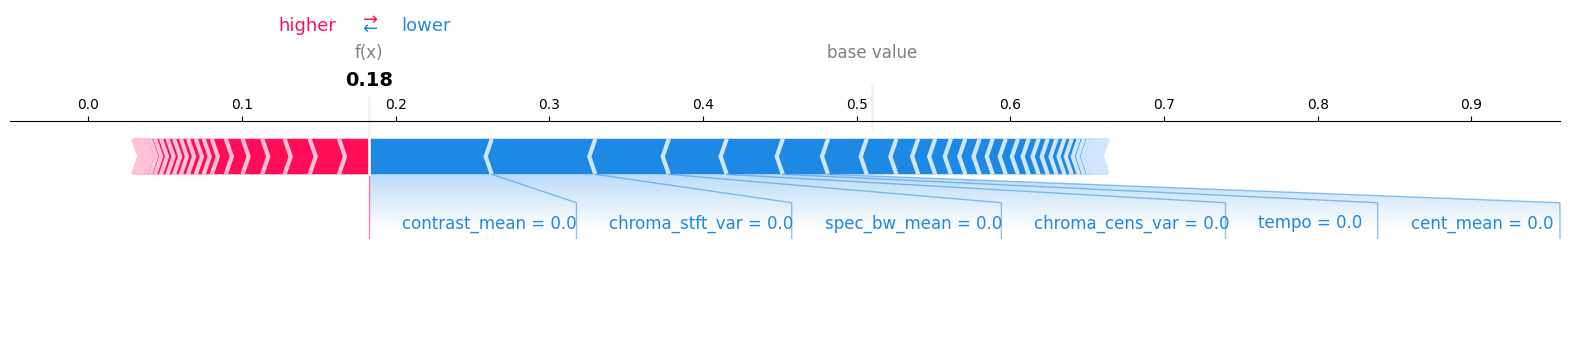

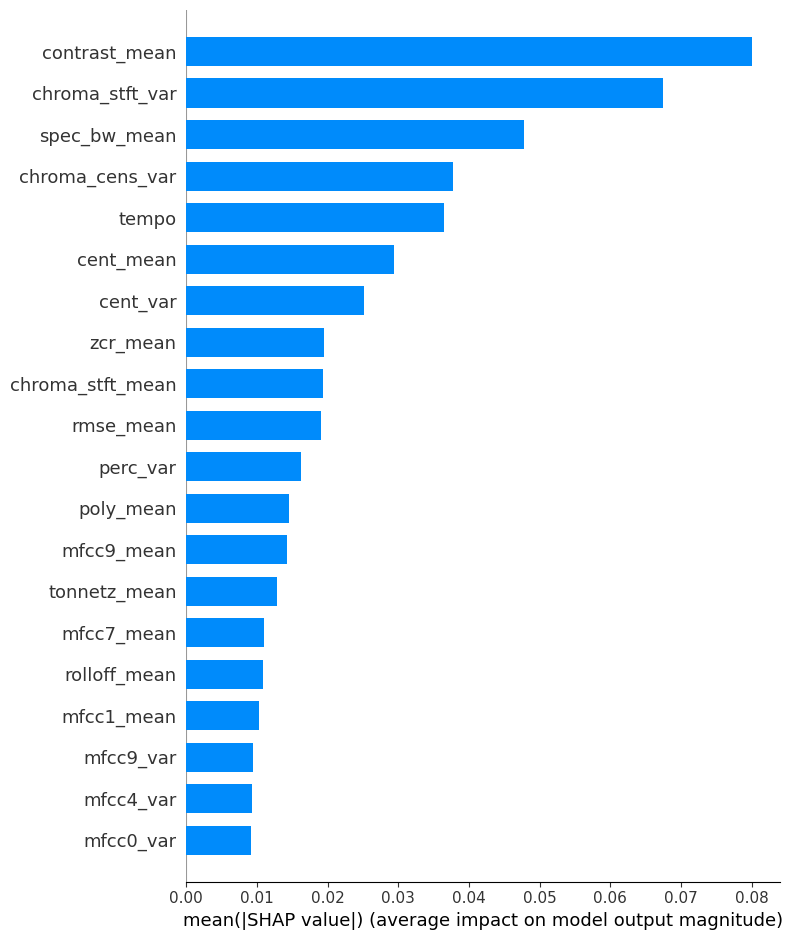

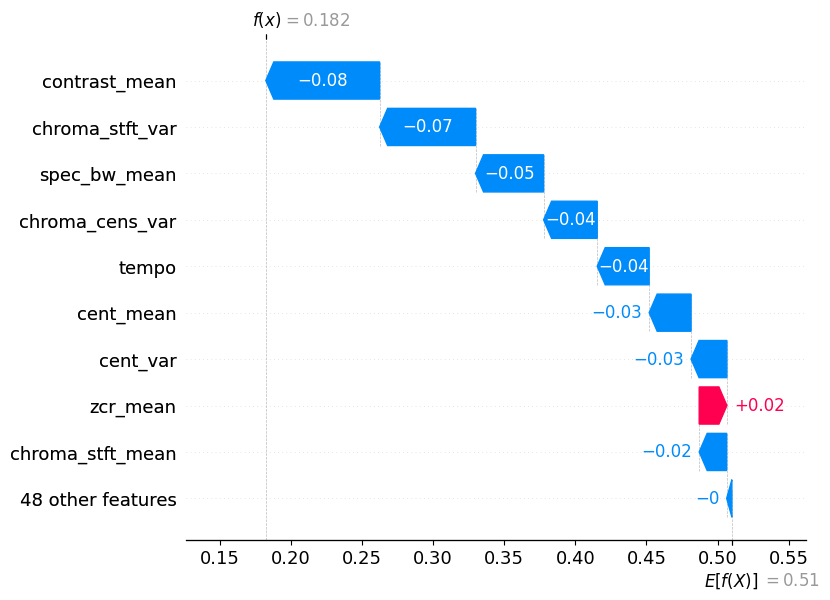

In [61]:
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Initialize the model
model = FlexibleMLP(input_size=X_train.shape[1], hidden_sizes=[256, 256, 256], output_size=1)

# Load pretrained weights
model.load_state_dict(torch.load('pretrained_MLP.pth'))
model.eval()

# Convert test and train data to tensors
X_train_tensor = torch.FloatTensor(X_train)  # Ensure X_train is a tensor
X_test_tensor = torch.FloatTensor(X_test_scaled_eg)

# Ensure DataLoader consistency
test_dataloader = DataLoader(X_test_tensor, batch_size=64, shuffle=False)

# Use a small background sample for SHAP DeepExplainer (avoid using full X_train to reduce computation time)
background_samples = X_train_tensor[np.random.choice(X_train_tensor.shape[0], size=100, replace=False)]

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background_samples)

# Compute SHAP values for the test dataset
shap_values = explainer.shap_values(X_test_tensor)

# Convert to numpy array
shap_values = np.array(shap_values[0])  # Extract SHAP values from list

# Ensure feature name count matches number of features in X_test_tensor
selected_feature_names = list(df.columns[:X_test_tensor.shape[1]])  # Extract the correct number of features
assert len(selected_feature_names) == X_test_tensor.shape[1], "Feature name mismatch!"

# --- PLOT 1: Force Plot for First Test Sample ---
# Select a single sample from test data
X_test_sample = X_test_tensor[0].detach().numpy()  # Convert to numpy

# Debugging step: print the shapes of X_test_tensor and shap_values
print(f"Shape of X_test_tensor: {X_test_tensor.shape}")
print(f"Shape of shap_values: {shap_values.shape}")

# Reshape shap_values to match the shape of X_test_tensor
shap_values = shap_values.T  # Transpose to shape (1, 57)

# Debug print to ensure correct shape after transposing
print(f"Reshaped shap_values to: {shap_values.shape}")

# Ensure shap_values matches the shape of X_test_tensor
assert shap_values.shape[1] == X_test_tensor.shape[1], "Shape mismatch between SHAP values and features"

# --- PLOT 1: Force Plot for First Test Sample ---
X_test_sample = X_test_tensor[0].detach().numpy()  # Convert to numpy
shap_values_sample = shap_values[0]  # SHAP values for the first sample
expected_value = explainer.expected_value[0]

shap.force_plot(expected_value, shap_values_sample, X_test_sample, 
                feature_names=selected_feature_names, matplotlib=True)

plt.show()

# Summary Plot (Bar) ---
shap.summary_plot(shap_values, X_test_tensor.numpy(), feature_names=selected_feature_names, plot_type="bar")

#  Waterfall Plot for First Test Sample ---

X_test_sample = X_test_tensor[0].detach().numpy()  # Convert to numpy
shap_values_sample = shap_values[0]  # SHAP values for the first sample
expected_value = explainer.expected_value[0]

# Create a SHAP Explanation object for the first test sample
shap_explanation = shap.Explanation(values=shap_values_sample, 
                                    base_values=expected_value, 
                                    feature_names=selected_feature_names)

# Generate the waterfall plot
shap.waterfall_plot(shap_explanation, max_display=10)  # Adjusting max_display to show top 10 features
plt.show()


# Model Prediction Analysis

### Overview
- **Base Value (E[f(x)])**: The base value is approximately **0.54**, indicating the expected output if features had no impact. This might reflect any class imbalance or model bias in the training data.
- **Output Value (f(x))**: The model's final prediction is **0.182**, which is above 0.5, suggesting a **negative class (0)** prediction. This value results from the base value adjusted by feature contributions.

### Feature Contributions
- **Positive Contributions (Red Bars)**: Features that increase the likelihood of predicting a negative class (0).
- **Negative Contributions (Blue Bars)**: Features that decrease the likelihood of predicting a negative class (0).

### Key Features
- **Top Contributor**: The feature **mse_mean** strongly pushes the prediction towards the positive class, indicating it significantly influences the outcome.
- **Other Important Features**: Features like **chroma_stft_var**, **contrast_mean** and **tempo** remains dominant, driving the prediction towards a negative outcome.
